In [13]:
##############################################################################
#                            XGB BOOST CLASSIFIER
##############################################################################

########## TABLE OF CONTENTS #############
#1. DATA READ IN
#2. DATA QUALITY CHECK
#3. DATA PREPARATION
#4. MODEL TRAINING -  BEST HYPER PARAMS SEARCH - RandomizedSearchCV
#5. MODEL TRAINING - MODEL DEVELOPMENT
#6. MODEL PERFORMANCE EVALUATION
#7. NEW MODEL - BEST HYPER PARAMS SEARCH - Compare Train vs Test Gini's to ensure lowest variance (limit overfitting)
#8. NEW MODEL TRAINING
#9. NEW MODEL PERFORMANCE EVALUATION

# Dataset -> Heart -> Taken from https://hastie.su.domains/ElemStatLearn/
# WARNING -> TOO FEW RECORDS TO PERFORM AN ADVANCED ML ALGO -> DONE IT FOR DEMO PURPOSES !
######################

# Boosting - An ensemble model is created to decrease model bias using a boosting approach.
# Boosting algorithms are a set of the weak classifiers to create a strong classifier.
# Strong classifiers offer error rate close to 0.
# Boosting algorithm can track the model who failed the accurate prediction.
# Boosting algorithms are less affected by the overfitting problem.



from xgboost import XGBClassifier
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
import scipy 
from scipy import stats 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, auc
import statsmodels.formula.api as smf
import math
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import RandomizedSearchCV, validation_curve, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
import shap 
from shap import TreeExplainer, Explanation
from shap.plots import waterfall
from sklearn.model_selection import learning_curve

1. DATA READ IN

In [14]:
df = pd.read_csv("Heart.txt", index_col=0)
df

df['TrainTestFlag'] = 0
df.iloc[pd.Series(df.index).sample(frac=0.5, random_state=1234), df.columns.get_loc('TrainTestFlag')] = 1
print("Train vs Test sample")
print(df['TrainTestFlag'].value_counts())
print("")
print(df['chd'].value_counts())
print("")
df.shape
df.info()


# sbp		systolic blood pressure
# tobacco	cumulative tobacco (kg)
# ldl		low densiity lipoprotein cholesterol
# adiposity
# famhist	family history of heart disease (Present, Absent)
# typea		type-A behavior
# obesity
# alcohol	current alcohol consumption
# age		age at onset
# chd		response, coronary heart disease  -> TARGET VARIABLE


Train vs Test sample
TrainTestFlag
0    231
1    231
Name: count, dtype: int64

chd
0    302
1    160
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 1 to 463
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sbp            462 non-null    int64  
 1   tobacco        462 non-null    float64
 2   ldl            462 non-null    float64
 3   adiposity      462 non-null    float64
 4   famhist        462 non-null    object 
 5   typea          462 non-null    int64  
 6   obesity        462 non-null    float64
 7   alcohol        462 non-null    float64
 8   age            462 non-null    int64  
 9   chd            462 non-null    int64  
 10  TrainTestFlag  462 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 43.3+ KB


2. DATA QUALITY CHECK

Checking duplicates
0

Univariate Analysis


,Feature,Feature Type,# Records,# Zero's,% Zero's,# Missing,% Missing,Minimum,Mean,Median,Maximum,Skewness,Kurtosis,Normality (p > 0.05)
0,sbp,int64,462.0,0.0,0.00,0.0,0.0,101.00,138.33,134.00,218.00,1.18,1.78,0.000
0,tobacco,float64,462.0,107.0,2.11,0.0,0.0,0.00,3.64,2.00,31.20,2.08,5.97,0.000
0,ldl,float64,462.0,0.0,0.00,0.0,0.0,0.98,4.74,4.34,15.33,1.31,2.88,0.000
0,adiposity,float64,462.0,0.0,0.00,0.0,0.0,6.74,25.41,26.12,42.49,-0.21,-0.70,0.000
0,typea,int64,462.0,0.0,0.00,0.0,0.0,13.00,53.10,53.00,78.00,-0.35,0.47,0.002
0,obesity,float64,462.0,0.0,0.00,0.0,0.0,14.70,26.04,25.80,46.58,0.91,2.26,0.000
0,alcohol,float64,462.0,110.0,2.16,0.0,0.0,0.00,17.04,7.51,147.19,2.31,6.42,0.000
0,age,int64,462.0,0.0,0.00,0.0,0.0,15.00,42.82,45.00,64.00,-0.38,-1.02,0.000
0,chd,int64,462.0,302.0,5.94,0.0,0.0,0.00,0.35,0.00,1.00,0.65,-1.59,0.000
0,familiarity,int32,462.0,270.0,5.31,0.0,0.0,0.00,0.42,0.00,1.00,0.34,-1.89,0.000




Train Sample - Correlation Analysis


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,familiarity
sbp,1.000000,0.233283,0.207580,0.385809,0.006982,0.234404,0.056174,0.374447,0.193223,-0.012011
tobacco,0.233283,1.000000,0.178263,0.301028,-0.019072,0.149317,0.121970,0.470611,0.235672,0.059423
ldl,0.207580,0.178263,1.000000,0.506813,-0.034983,0.350632,-0.019253,0.359990,0.219369,0.178233
adiposity,0.385809,0.301028,0.506813,1.000000,-0.099006,0.671724,0.090994,0.626552,0.246833,0.135851
typea,0.006982,-0.019072,-0.034983,-0.099006,1.000000,0.059974,0.089611,-0.130366,0.051555,-0.005536
obesity,0.234404,0.149317,0.350632,0.671724,0.059974,1.000000,0.033501,0.289105,0.106953,0.059364
alcohol,0.056174,0.121970,-0.019253,0.090994,0.089611,0.033501,1.000000,0.132030,0.068481,0.123137
age,0.374447,0.470611,0.359990,0.626552,-0.130366,0.289105,0.132030,1.000000,0.363721,0.216936
chd,0.193223,0.235672,0.219369,0.246833,0.051555,0.106953,0.068481,0.363721,1.000000,0.247746
familiarity,-0.012011,0.059423,0.178233,0.135851,-0.005536,0.059364,0.123137,0.216936,0.247746,1.000000


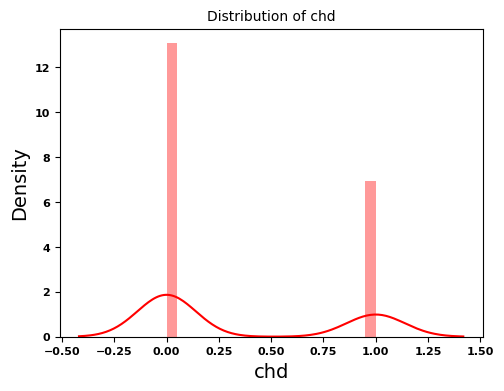

In [15]:
df = pd.read_csv("Heart.txt", index_col=0)
df['familiarity'] = np.where(df['famhist'] == "Absent",0,np.where(df['famhist'] == "Present",1,-1))

df = df.drop(columns=['famhist'], axis=1)

df['TrainTestFlag'] = 0
df.iloc[pd.Series(df.index).sample(frac=0.5, random_state=1234), df.columns.get_loc('TrainTestFlag')] = 1

# Check for exact duplicates
print("Checking duplicates")
print(df.duplicated(keep=False).sum())
print("")
# Univariate Analysis
print("Univariate Analysis")
chars = df.columns

d = pd.DataFrame(index = [0],columns=['Feature','Feature Type','# Records',"# Zero's","% Zero's","# Missing","% Missing","Minimum", "Mean", "Median", "Maximum", "Skewness","Kurtosis","Normality (p > 0.05)"])
d.to_csv('univariateAnalysis.csv')      

notApplicable = "N/A"
for z in range(len(chars)):
    a = pd.read_csv('univariateAnalysis.csv',index_col=0)  
    if(df[chars[z]].dtype !='object'):
        k2, p = stats.normaltest(df[chars[z]])
        dd = pd.DataFrame({'Feature':[chars[z]],
                            'Feature Type':df[chars[z]].dtype,
                            "# Records":len(df),
                            "# Zero's": (df[chars[z]] == 0).sum(),
                            "% Zero's" : round((df[chars[z]] == 0).sum()/df.size*100,2),
                            "# Missing" : (df[chars[z]].isna()).sum(),
                            "% Missing" : round((df[chars[z]].isna()).sum()/df.size*100,2),
                            "Minimum" : round(df[chars[z]].min(),2),
                            "Mean" : round(df[chars[z]].mean(),2),
                            "Median" : round(df[chars[z]].median(),2),
                            "Maximum" : round(df[chars[z]].max(),2),
                            "Skewness" : round(df[chars[z]].skew(),2), #Positive Skewness -> LEFT SKEW -> -> Threshold is -0.5 < x < 0.5
                            "Kurtosis" : round(df[chars[z]].kurt(),2), #Negative Kurtosis -> FAT TAILS -> -> Threshold is 3
                            "Normality (p > 0.05)" : round(p,3)}
                            )
        s = pd.concat([a, dd])
        s = s.dropna()
        s.to_csv('univariateAnalysis.csv')

    else:
        dd = pd.DataFrame({'Feature':[chars[z]],
                    'Feature Type':df[chars[z]].dtype,
                    "# Records": len(df),
                    "# Zero's": (df[chars[z]] == 0).sum(),
                    "% Zero's" : round((df[chars[z]] == 0).sum()/len(df)*100,1),
                    "# Missing" : (df[chars[z]].isna()).sum(),
                    "% Missing" : round((df[chars[z]].isna()).sum()/df.size*100,1),
                    "Minimum" : [notApplicable],
                    "Mean" : [notApplicable],
                    "Median" : [notApplicable],
                    "Maximum" : [notApplicable],
                    "Skewness" : [notApplicable],
                    "Kurtosis" : [notApplicable],
                    "Normality (p > 0.05)" : [notApplicable]}
                    )

        s = pd.concat([a, dd])
        s = s.dropna()
        s.to_csv('univariateAnalysis.csv')
display(s)
print("")


# Distribution of target variable
f= plt.figure(figsize=(12,4))
ax=f.add_subplot(121)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.distplot(df['chd'],bins=20,color='r',ax=ax)
ax.set_title('Distribution of chd',fontsize = 10)



#Split Train vs Test -> 50% vs 50%
train = df.loc[df['TrainTestFlag'] == 1]
test = df.loc[df['TrainTestFlag'] == 0]


# Correlation
# Do I need to remove correlated features? 
# The short answer is no. It does not affect prediction accuracy.
# But do correlation anaylysis anyway.

print("")
print("Train Sample - Correlation Analysis")
ds = train.drop(columns=['TrainTestFlag'], axis=1)
corr = ds.corr()
display(corr.style.background_gradient(cmap='coolwarm'))
print("")


3. DATA PREPARATION

In [19]:
X = ds.drop(columns=['chd'], axis = 1)
Y = ds['chd']

pred_features = X.columns
print(pred_features)

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol',
       'age', 'familiarity'],
      dtype='object')


4. MODEL TRAINING -  BEST HYPER PARAMS SEARCH - RandomizedSearchCV

In [22]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.50, random_state = 42)


# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 2,3,4,5,6,7,8,9,10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6,7,8,9],
        'learning_rate' : [0.01,0.03,0.05,0.07, 0.1,0.2]
        }
   
xgb = XGBClassifier( n_estimators=60, objective='binary:logistic', #learning_rate=0.02,
                silent=True, nthread=1)

folds = 3
param_comb = 6

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

# Here we go

random_search.fit(X, Y)

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)
print("")
print("Grid Search: complete.")
print("")

Fitting 3 folds for each of 6 candidates, totalling 18 fits

 All results:
{'mean_fit_time': array([0.01939583, 0.02304546, 0.01253033, 0.01277161, 0.0131255 ,
       0.01129897]), 'std_fit_time': array([0.00173386, 0.00208458, 0.00138805, 0.00212153, 0.00106308,
       0.00088338]), 'mean_score_time': array([0.00416199, 0.00303817, 0.00351016, 0.00269707, 0.003491  ,
       0.00314697]), 'std_score_time': array([0.00024641, 0.00067463, 0.00040392, 0.00049442, 0.00104909,
       0.00040785]), 'param_subsample': masked_array(data=[0.6, 0.8, 1.0, 1.0, 0.6, 0.6],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[2, 1, 7, 6, 7, 1],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[6, 5, 5, 3, 6, 4],
             mask=[False, False, False, False, False, False],
       fill_value='?',
   

5. MODEL TRAINING - MODEL DEVELOPMENT

age            1.0
sbp            0.0
tobacco        0.0
ldl            0.0
adiposity      0.0
typea          0.0
obesity        0.0
alcohol        0.0
familiarity    0.0
dtype: float32


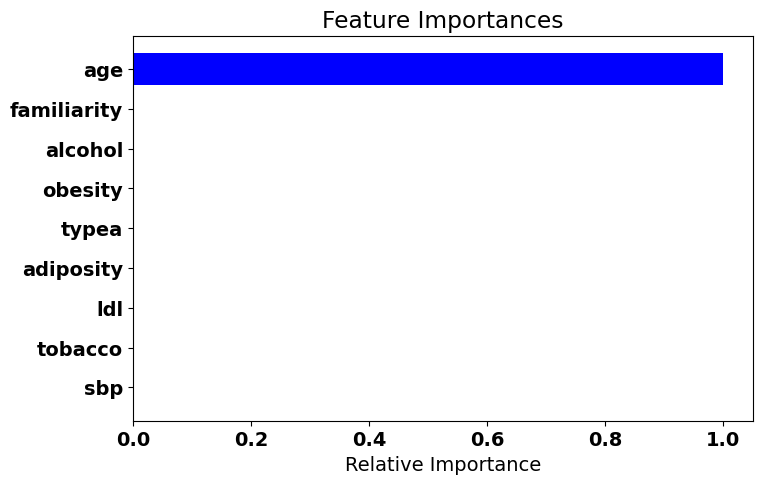


Calculate SHAP globally ....


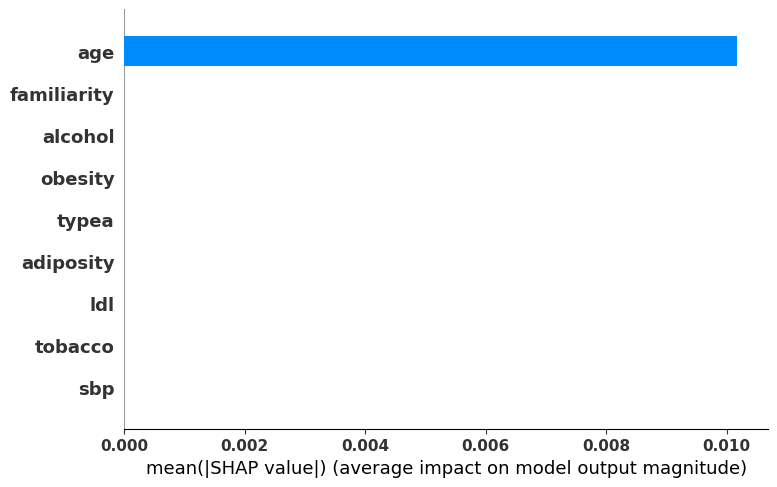

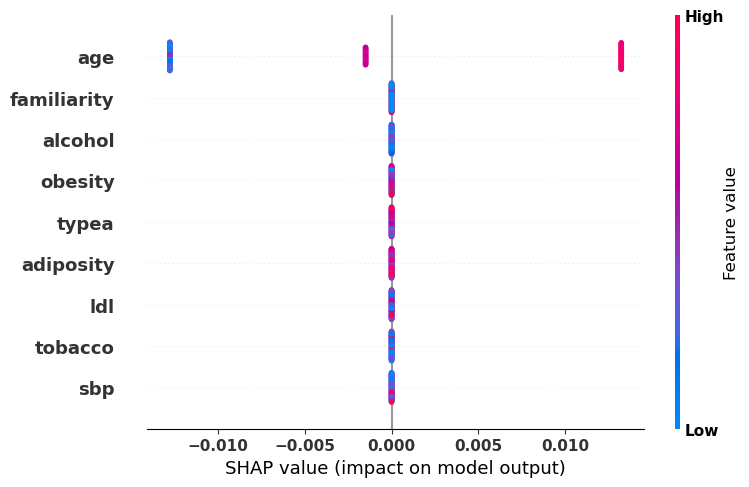

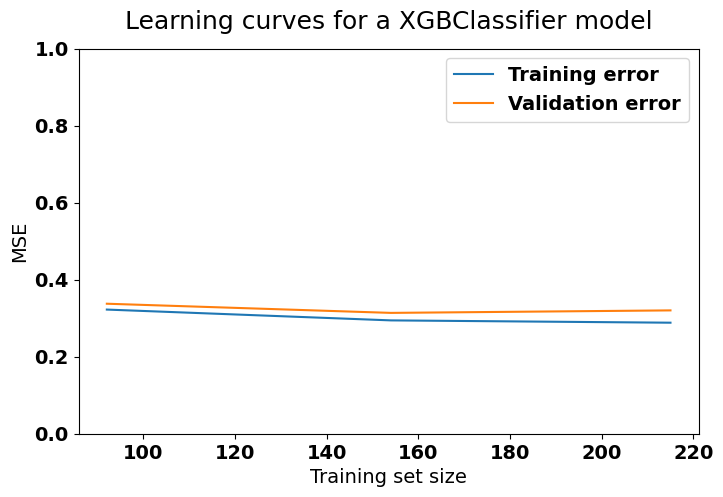

In [26]:
# fit model no training data
clf = XGBClassifier(
        objective='binary:logistic',
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bynode=1,
        colsample_bytree=0.8,
        enable_categorical=False,
        gamma=2,
        gpu_id=-1,
        importance_type=None,
        learning_rate=0.01,
        max_delta_step=0,
        max_depth=6,
        min_child_weight=7,
        n_estimators=2,
        n_jobs=1,
        nthread=1,
        num_parallel_tree=1,
        predictor='auto',
        random_state=0,
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        subsample=0.6,
        tree_method='exact',
        validate_parameters=1,
        verbosity=None)

clf.fit(X_train, y_train)

# Print features importance
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

# Plot features importance
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [pred_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# Impurity-base importance explains the feature usage for generalizing on the train set;
# Permutation importance explains the contribution of a feature to the model accuracy;
# SHAP explains how much would changing a feature value affect the prediction (not necessarily correct).

print("")
print("Calculate SHAP globally ....")

# Variable Importance - Global Interpretability
#[x_train
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")


# positive and negative relationships of the predictors with the target variable
shap.summary_plot(shap_values, X_train)    
print("")


# Plot Learning Curve
def learning_curves(estimator, data, features, target, train_sizes , cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =  train_sizes ,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)

train_sizes = [0.3,0.5,0.7]
learning_curves(clf, df, pred_features, 'chd', train_sizes, 3)




6. MODEL PERFORMANCE EVALUATION

Model accuracy score on Train Sample : 0.6696
Model accuracy score on Test Sample: 0.6638
Confusion matrix

 [[77  0]
 [39  0]]
              precision    recall  f1-score   support

           0       0.66      1.00      0.80        77
           1       0.00      0.00      0.00        39

    accuracy                           0.66       116
   macro avg       0.33      0.50      0.40       116
weighted avg       0.44      0.66      0.53       116

Gini for Train Sample is 41.558



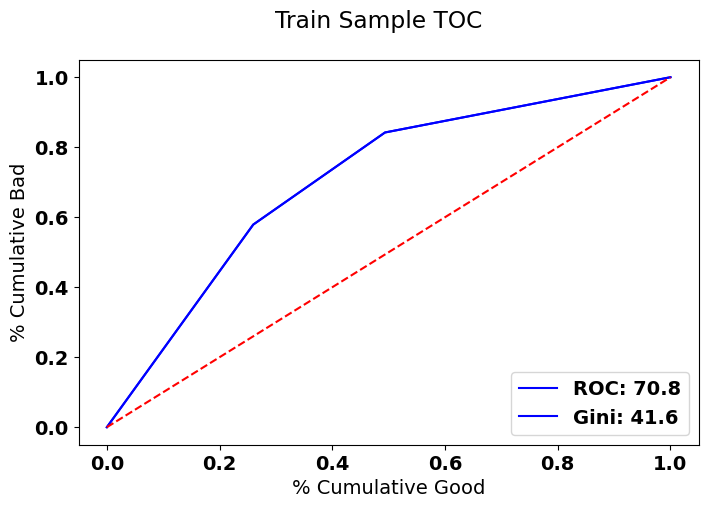

Gini for Test Sample is 35.531



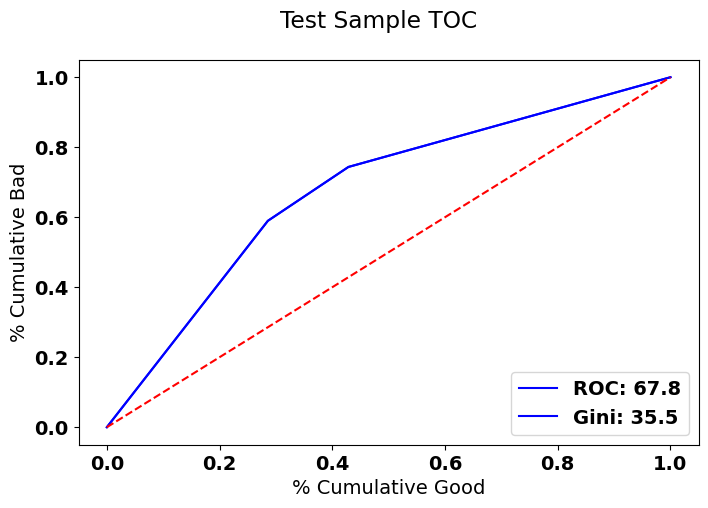

In [28]:
# Accuracy Score on Train Sample
y_pred = clf.predict(X_train)
print('Model accuracy score on Train Sample : {0:0.4f}'. format(accuracy_score(y_train, y_pred)))

#Accuracy Score on Train Sample
y_pred = clf.predict(X_test)
print('Model accuracy score on Test Sample: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

# Confusion Matrix (on Test Sample)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))
    
# Gini calculation on Train Sample
y_pred_proba = clf.predict_proba(X_train)[:,1]
[fpr, tpr, thr] = roc_curve(y_train, y_pred_proba)
rocauc=auc(fpr,tpr)*100
Gini = (auc(fpr, tpr)-0.5)*200
print("Gini for Train Sample is %2.3f" % Gini)
print("")

fig = plt.figure()    
fig.suptitle('Train Sample TOC')
ax1 = fig.add_subplot(1,1,1)
plt.plot(fpr,tpr,'b',label='ROC: %0.1f'% rocauc)
plt.plot(fpr,tpr,'b',label='Gini: %0.1f'% Gini)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('% Cumulative Good')
plt.ylabel('% Cumulative Bad')
plt.show()


    
# Gini calculation on Test Sample
y_pred_proba = clf.predict_proba(X_test)[:,1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
rocauc=auc(fpr,tpr)*100
Gini = (auc(fpr, tpr)-0.5)*200
print("Gini for Test Sample is %2.3f" % Gini)
print("")

fig = plt.figure()    
fig.suptitle('Test Sample TOC')
ax1 = fig.add_subplot(1,1,1)
plt.plot(fpr,tpr,'b',label='ROC: %0.1f'% rocauc)
plt.plot(fpr,tpr,'b',label='Gini: %0.1f'% Gini)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('% Cumulative Good')
plt.ylabel('% Cumulative Bad')
plt.show()


7. NEW MODEL - BEST HYPER PARAMS SEARCH - Compare Train vs Test Gini's to ensure lowest variance (limit overfitting)

,Unnamed: 0,min_child_weight,subsample,colsample_bytree,max_depth,learning_rate,Train Gini,Test Gini,Gini Difference
3029,0,8.0,0.6,0.6,3.0,0.20,0.324675,0.451548,0.126873
3035,0,8.0,0.6,0.6,4.0,0.20,0.324675,0.451548,0.126873
3041,0,8.0,0.6,0.6,5.0,0.20,0.324675,0.451548,0.126873
3047,0,8.0,0.6,0.6,6.0,0.20,0.324675,0.451548,0.126873
3053,0,8.0,0.6,0.6,7.0,0.20,0.324675,0.451548,0.126873
...,...,...,...,...,...,...,...,...,...
2924,0,7.0,1.0,0.6,10.0,0.05,0.440875,0.052947,-0.387928
2925,0,7.0,1.0,0.6,10.0,0.07,0.440875,0.052947,-0.387928
2926,0,7.0,1.0,0.6,10.0,0.10,0.440875,0.052947,-0.387928
2927,0,7.0,1.0,0.6,10.0,0.20,0.440875,0.052947,-0.387928


Text(0, 0.5, 'Test Gini')

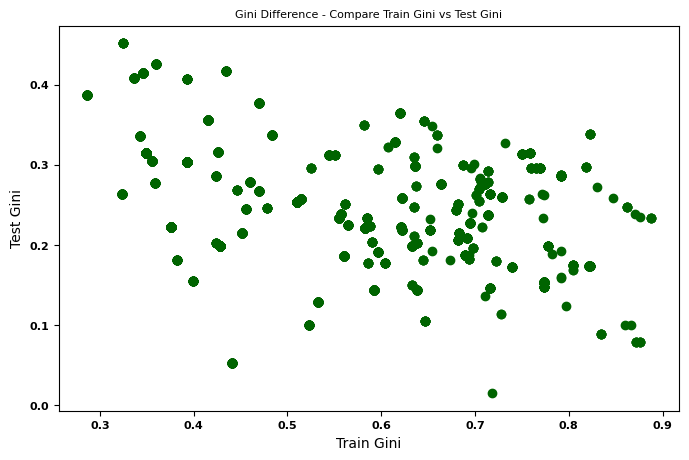

In [44]:
if False:
    d = pd.DataFrame(index = [0],columns=['min_child_weight','subsample',"colsample_bytree","max_depth","learning_rate","Train Gini", "Test Gini"])
    d.to_csv('XGBoosttHyperParams.csv')  

    min_child_weight = [1, 2,3,4,5,6,7,8,9,10]
    subsample = [0.6, 0.8, 1.0]
    colsample_bytree = [0.6, 0.8, 1.0]
    max_depth = [3, 4, 5,6,7,8,9,10]
    learning_rate = [0.01,0.03,0.05,0.07, 0.1,0.2]

    print("Number of Iterations")
    print(len(min_child_weight) * len(gamma) * len(subsample) * len(colsample_bytree) * len(max_depth) * len(learning_rate))


    for i in range(len(min_child_weight)):
        for j in range(len(subsample)):
            for k in range(len(colsample_bytree)):
                for l in range(len(max_depth)):
                    for m in range(len(learning_rate)):

                        # fit model no training data
                        clf = XGBClassifier(
                                objective='binary:logistic',
                                base_score=0.5,
                                booster='gbtree',
                                colsample_bylevel=1,
                                colsample_bynode=1,
                                colsample_bytree=colsample_bytree[k],
                                enable_categorical=False,
                                gamma=2,
                                gpu_id=-1,
                                importance_type=None,
                                learning_rate=learning_rate[m],
                                max_delta_step=0,
                                max_depth=max_depth[l],
                                min_child_weight=min_child_weight[i],
                                n_estimators=2,
                                n_jobs=1,
                                nthread=1,
                                num_parallel_tree=1,
                                predictor='auto',
                                random_state=0,
                                reg_alpha=0,
                                reg_lambda=1,
                                scale_pos_weight=1,
                                subsample=subsample[j],
                                tree_method='exact',
                                validate_parameters=1,
                                verbosity=None)

                        clf.fit(X_train, y_train)

                        # Gini calculation on Train Sample
                        y_pred_proba = clf.predict_proba(X_train)[:,1]
                        [fpr, tpr, thr] = roc_curve(y_train, y_pred_proba)
                        GiniTrain = (auc(fpr, tpr)-0.5)*2

                            
                        # Gini calculation on Test Sample
                        y_pred_proba = clf.predict_proba(X_test)[:,1]
                        [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
                        GiniTest = (auc(fpr, tpr)-0.5)*2


                        a = pd.read_csv('XGBoosttHyperParams.csv',index_col=0)  
                        dd = pd.DataFrame(
                                        {
                                        'min_child_weight':[min_child_weight[i]],
                                        'subsample' : subsample[j],
                                        'colsample_bytree':colsample_bytree[k],
                                        "max_depth":max_depth[l],
                                        "learning_rate": learning_rate[m],
                                        "Train Gini" : GiniTrain,
                                        "Test Gini" : GiniTest

                                        }
                                        )
                        s = pd.concat([a, dd])
                        s = s.dropna()
                        s.to_csv('XGBoosttHyperParams.csv')
    display(s)

s = pd.read_csv("XGBoosttHyperParams.csv")
s['Gini Difference'] = s['Test Gini'] - s['Train Gini']
s = s.loc[s['Test Gini'] > 0]
dd = s.sort_values(by=['Test Gini','Gini Difference'], ascending=False)
display(dd)

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.scatter(x=s['Train Gini'],
                    y=s['Test Gini'],
                    c='DarkGreen')
ax1.set_title("Gini Difference - Compare Train Gini vs Test Gini", fontsize=8)
ax1.set_xlabel("Train Gini", fontsize = 10)
ax1.set_ylabel("Test Gini", fontsize = 10)




8. NEW MODEL TRAINING

age            0.715223
familiarity    0.284777
sbp            0.000000
tobacco        0.000000
ldl            0.000000
adiposity      0.000000
typea          0.000000
obesity        0.000000
alcohol        0.000000
dtype: float32


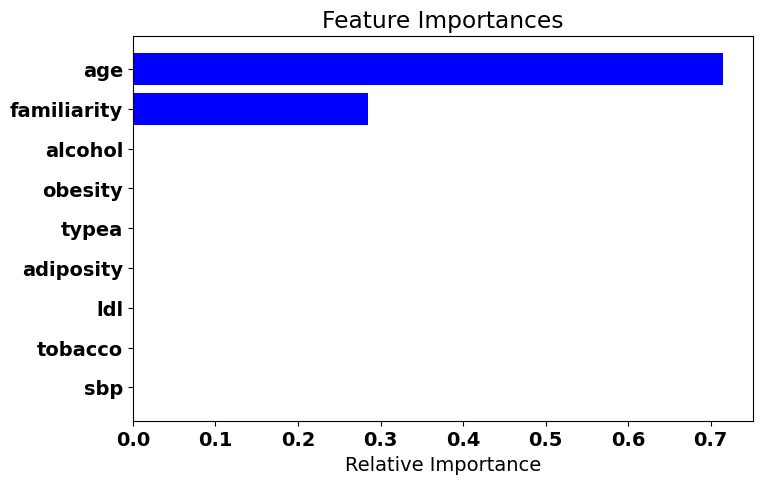


Calculate SHAP globally ....


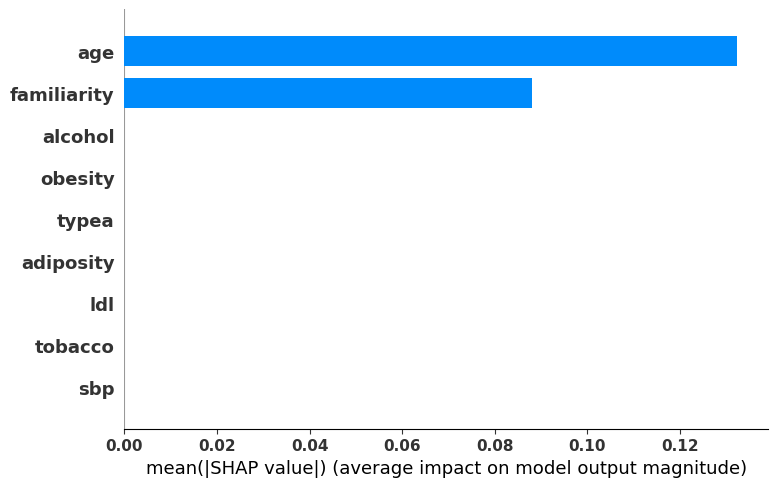

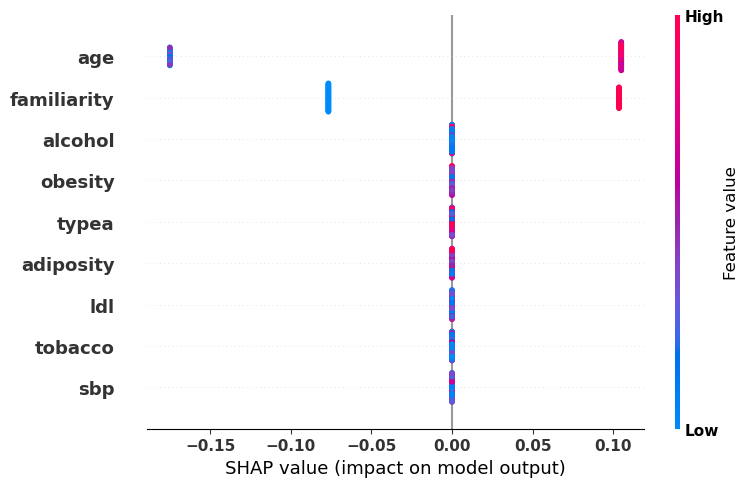

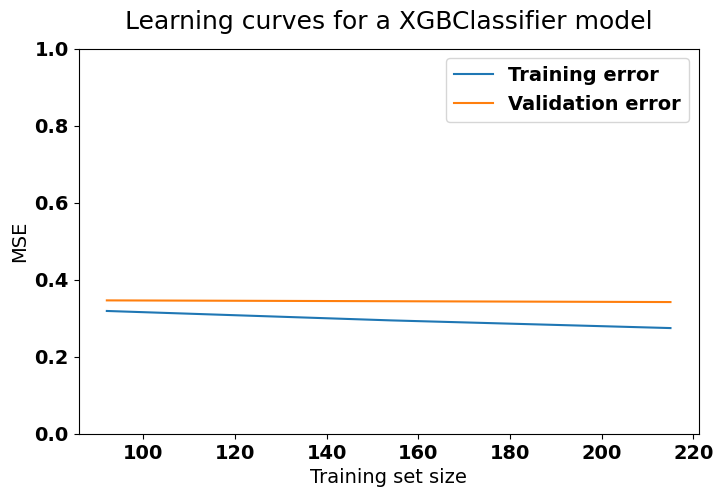

In [43]:
# fit model no training data
clf = XGBClassifier(
        objective='binary:logistic',
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bynode=1,
        colsample_bytree=1,
        enable_categorical=False,
        gamma=2,
        gpu_id=-1,
        importance_type=None,
        learning_rate=0.2,
        max_delta_step=0,
        max_depth=10,
        min_child_weight=9,
        n_estimators=2,
        n_jobs=1,
        nthread=1,
        num_parallel_tree=1,
        predictor='auto',
        random_state=0,
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        subsample=0.8,
        tree_method='exact',
        validate_parameters=1,
        verbosity=None)

clf.fit(X_train, y_train)

# Print features importance
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

# Plot features importance
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [pred_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# Impurity-base importance explains the feature usage for generalizing on the train set;
# Permutation importance explains the contribution of a feature to the model accuracy;
# SHAP explains how much would changing a feature value affect the prediction (not necessarily correct).

print("")
print("Calculate SHAP globally ....")

# Variable Importance - Global Interpretability
#[x_train
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")


# positive and negative relationships of the predictors with the target variable
shap.summary_plot(shap_values, X_train)    
print("")


# Plot Learning Curve
def learning_curves(estimator, data, features, target, train_sizes , cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =  train_sizes ,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)

train_sizes = [0.3,0.5,0.7]
learning_curves(clf, df, pred_features, 'chd', train_sizes, 3)


9. NEW MODEL PERFORMANCE EVALUATION

Model accuracy score on Train Sample : 0.6957
[0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1
 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0
 0 0 1 0]
Model accuracy score on Test Sample: 0.7069
[0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0
 0 0 0 0 0]
Confusion matrix

 [[64 13]
 [21 18]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        77
           1       0.58      0.46      0.51        39

    accuracy                           0.71       116
   macro avg       0.67      0.65      0.65       116
weighted avg       0.70      0.71      0.70       116

Gini for Train Sample is 43.472



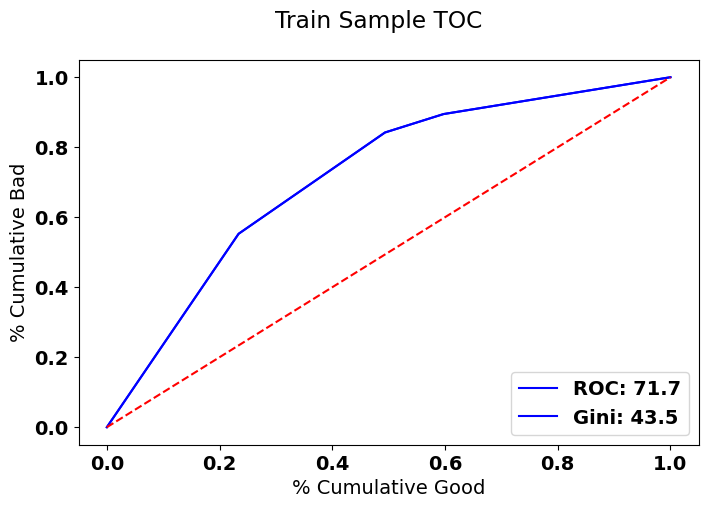

Gini for Test Sample is 41.725



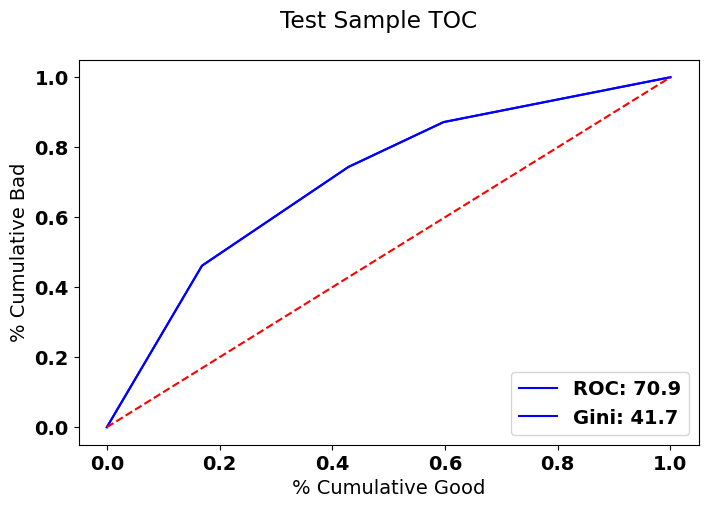

In [45]:
# Accuracy Score on Train Sample
y_pred = clf.predict(X_train)
print('Model accuracy score on Train Sample : {0:0.4f}'. format(accuracy_score(y_train, y_pred)))
print(y_pred)
#Accuracy Score on Train Sample
y_pred = clf.predict(X_test)
print('Model accuracy score on Test Sample: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(y_pred)
# Confusion Matrix (on Test Sample)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))
    
# Gini calculation on Train Sample
y_pred_proba = clf.predict_proba(X_train)[:,1]
[fpr, tpr, thr] = roc_curve(y_train, y_pred_proba)
rocauc=auc(fpr,tpr)*100
Gini = (auc(fpr, tpr)-0.5)*200
print("Gini for Train Sample is %2.3f" % Gini)
print("")

fig = plt.figure()    
fig.suptitle('Train Sample TOC')
ax1 = fig.add_subplot(1,1,1)
plt.plot(fpr,tpr,'b',label='ROC: %0.1f'% rocauc)
plt.plot(fpr,tpr,'b',label='Gini: %0.1f'% Gini)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('% Cumulative Good')
plt.ylabel('% Cumulative Bad')
plt.show()

    
# Gini calculation on Test Sample
y_pred_proba = clf.predict_proba(X_test)[:,1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
rocauc=auc(fpr,tpr)*100
Gini = (auc(fpr, tpr)-0.5)*200
print("Gini for Test Sample is %2.3f" % Gini)
print("")

fig = plt.figure()    
fig.suptitle('Test Sample TOC')
ax1 = fig.add_subplot(1,1,1)
plt.plot(fpr,tpr,'b',label='ROC: %0.1f'% rocauc)
plt.plot(fpr,tpr,'b',label='Gini: %0.1f'% Gini)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('% Cumulative Good')
plt.ylabel('% Cumulative Bad')
plt.show()